# Setup

## Imports 

In [1]:
# Standard
import sys
# Third party
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import proplot as plot
# Local                                                                        
sys.path.append('/Users/46h/Research/code/accphys/') 
from tools import (
    envelope_analysis as ea,
    plotting as myplt,
    animation as myanim,
    utils)
from tools.utils import show, play, vec2mat, list_files, file_exists
from tools.plotting import save, set_labels

## Settings
Here are the available [stylesheets](https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html) and [color cycles](https://proplot.readthedocs.io/en/latest/cycles.html).

In [2]:
# Plotting
plt_kws = dict(
    lw=None, # set nonzero to have points connecting markers
    marker='.',
    markersize=3,
    legend=False,
)
plot.rc['figure.facecolor'] = 'white'
plot.rc['cycle'] = 'default'
plot.rc['style'] = None # https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html
plot.rc['savefig.dpi'] = 'figure' # proplot default is 1200, which makes inline animations appear huge
dpi = 500

# Animation
t0, t1 = 0, 10 # initial/final frames
skip = 0
fps = 3
anim_dpi = None

In [3]:
# Data file locations
files = {
    'env_params': '_output/data/envelope/env_params.npy',
    'testbunch_coords': '_output/data/envelope/testbunch_coords.npy',
    'bunch_coords': '_output/data/bunch/bunch_coords.npy',
    'bunch_moments': '_output/data/bunch/bunch_moments.npy',
    'transfer_matrix': '_output/data/transfer_matrix.npy'
}
# Check if files exist
files_exist = {key: file_exists(file) for key, file in files.items()}

# Directories in which to save the figures
dirs = {
    'env': './_output/figures/envelope/',
    'bunch': './_output/figures/bunch/',
    'comparison': './_output/figures/comparison/'
}

In [4]:
width, height = 3.5, 2.5

def setup_figure(opt=1):
    """Convenience function to create subplots."""
    if opt == 1:
        nrows, ncols, figsize = 1, 1, (width, height)
    elif opt == 2:
        nrows, ncols, figsize = 3, 1, (width, 2*height)
    elif opt == 3:
        nrows, ncols, figsize = 3, 2, (1.6*width, 2*height)
    elif opt == 4:
        nrows, ncols, figsize = 1, 2, (7, 2.5)
    fig, axes = plot.subplots(nrows=nrows, ncols=ncols, figsize=figsize, spany=False, aligny=True)
    axes.format(xlabel='Turn number')
    return fig, axes

# Envelope

In [5]:
mode = int(np.loadtxt('_output/data/mode.txt'))
env_params = np.load(files['env_params'])

env_stats = ea.Stats(mode)
env_stats.read_env(env_params)

## Twiss parameters 

### 2D Twiss

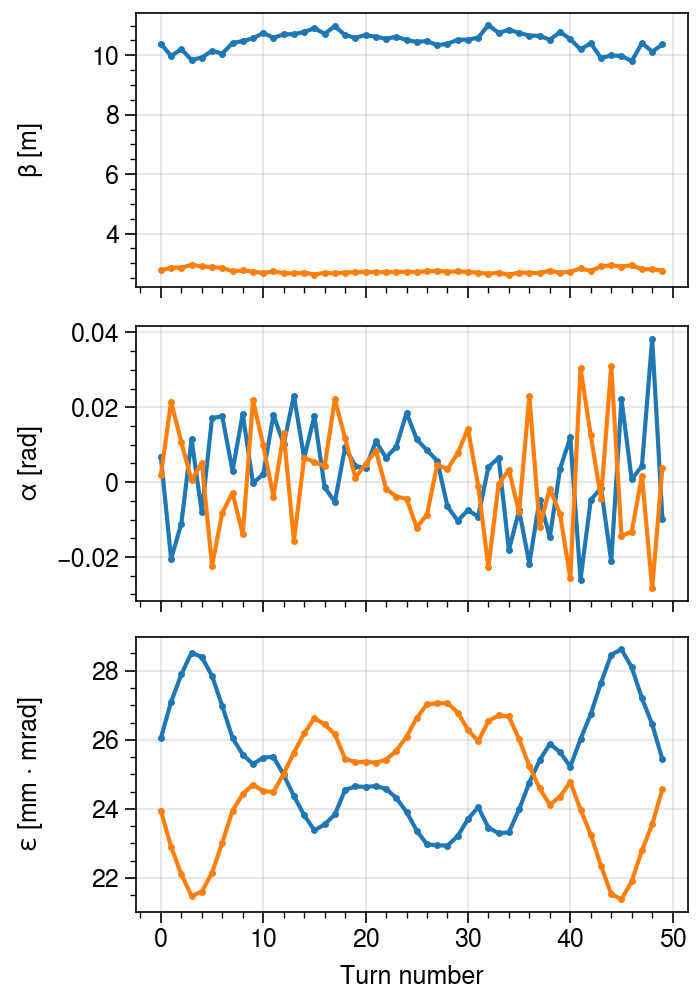

In [6]:
fig, axes = setup_figure(2);
columns = (['bx','by'], ['ax','ay'], ['ex','ey'])
ylabels = (r'$\beta$ [m]', r'$\alpha$ [rad]', r'$\varepsilon$ [mm $\cdot$ mrad]')
for ax, col in zip(axes, columns):
    env_stats.twiss2D[col].plot(ax=ax, **plt_kws)
set_labels(axes, ylabels, 'ylabel')
save('twiss2D', dirs['env'], dpi=dpi)

### 4D Twiss 

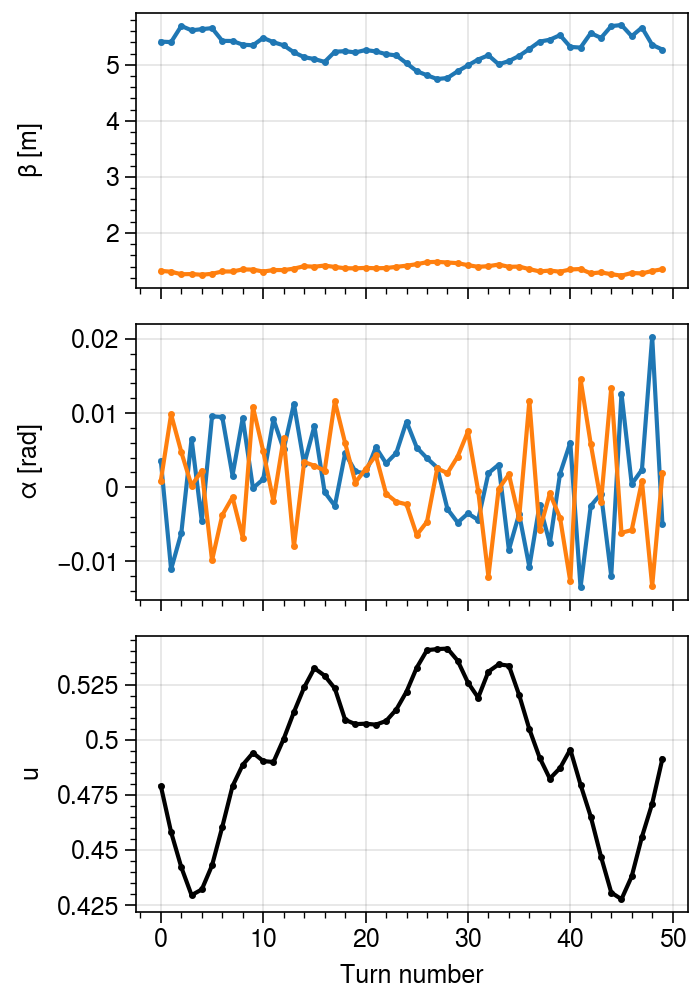

In [7]:
fig, axes = setup_figure(2)
env_stats.twiss4D[['bx','by']].plot(ax=axes[0], **plt_kws)
env_stats.twiss4D[['ax','ay']].plot(ax=axes[1], **plt_kws)
env_stats.twiss4D[['u']].plot(ax=axes[2], color='k', **plt_kws)
set_labels(axes, [r'$\beta$ [m]', r'$\alpha$ [rad]', r'$u$'], 'ylabel')
save('twiss4D', dirs['env'], dpi=dpi)

### Phase difference (nu)

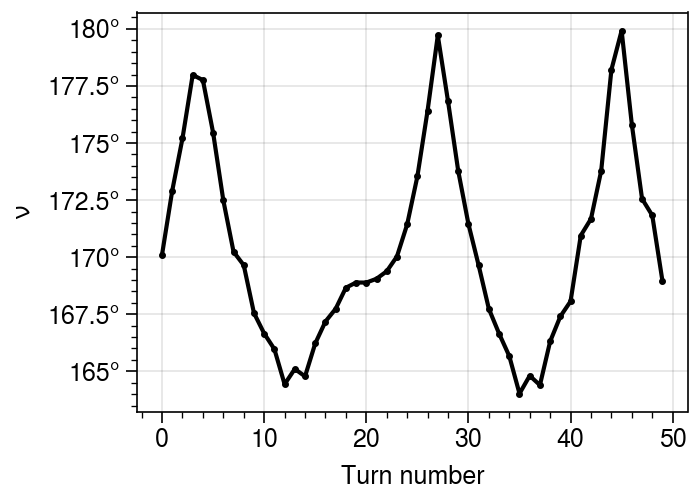

In [8]:
fig, ax = setup_figure(1)
env_stats.twiss4D['nu'].plot(color='k', ax=ax, **plt_kws)
ax.format(ylabel=r'$\nu$', yformatter='deg')
save('twiss4D-nu', dirs['env'], dpi=dpi)

### Emittance 

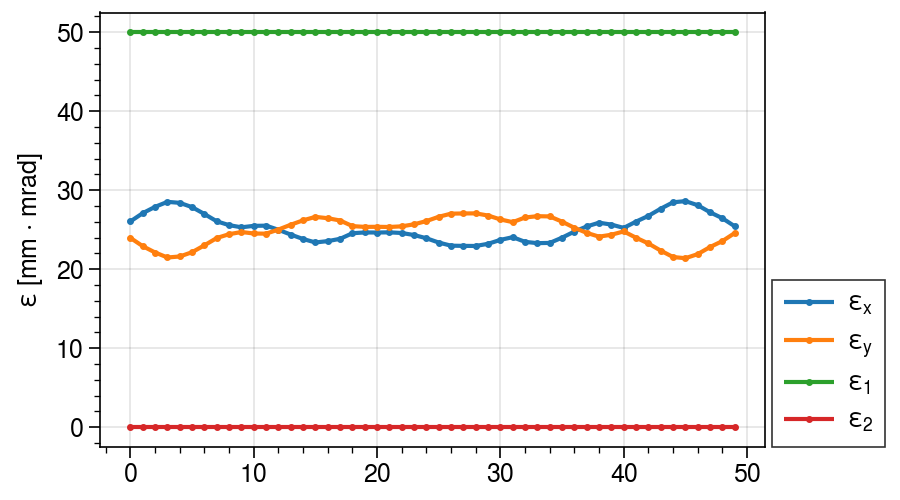

In [9]:
fig, ax = plot.subplots(figsize=(4.5, 2.5))
env_stats.twiss2D[['ex','ey']].plot(ax=ax, **plt_kws)
env_stats.twiss4D[['e1','e2']].plot(ax=ax, **plt_kws)
ax.format(ylabel=r'$\varepsilon$ [mm $\cdot$ mrad]')
ax.legend(labels=[r'$\varepsilon_x$', r'$\varepsilon_y$', r'$\varepsilon_1$', r'$\varepsilon_2$'], 
          ncols=1, loc=(1.01, 0))
save('emittance', dirs['env'], dpi=dpi)

## Moments 

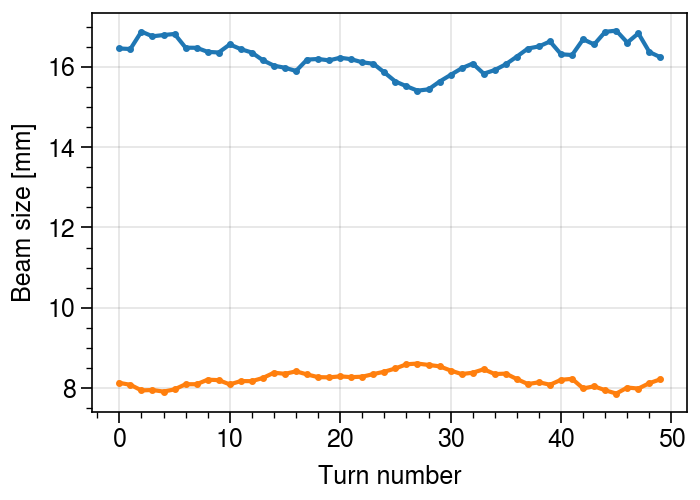

In [10]:
fig, ax = setup_figure(1)
env_stats.moments[['x_rms','y_rms']].plot(ax=ax, **plt_kws)
ax.format(ylabel='Beam size [mm]')
save('beamsize', dirs['env'], dpi=dpi)

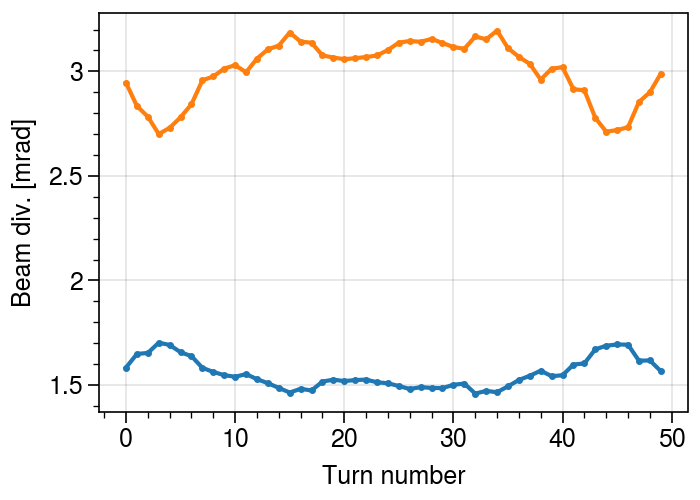

In [11]:
fig, ax = setup_figure(1)
env_stats.moments[['xp_rms','yp_rms']].plot(ax=ax, **plt_kws)
ax.format(ylabel='Beam div. [mrad]')
save('beamdiv', dirs['env'], dpi=dpi)

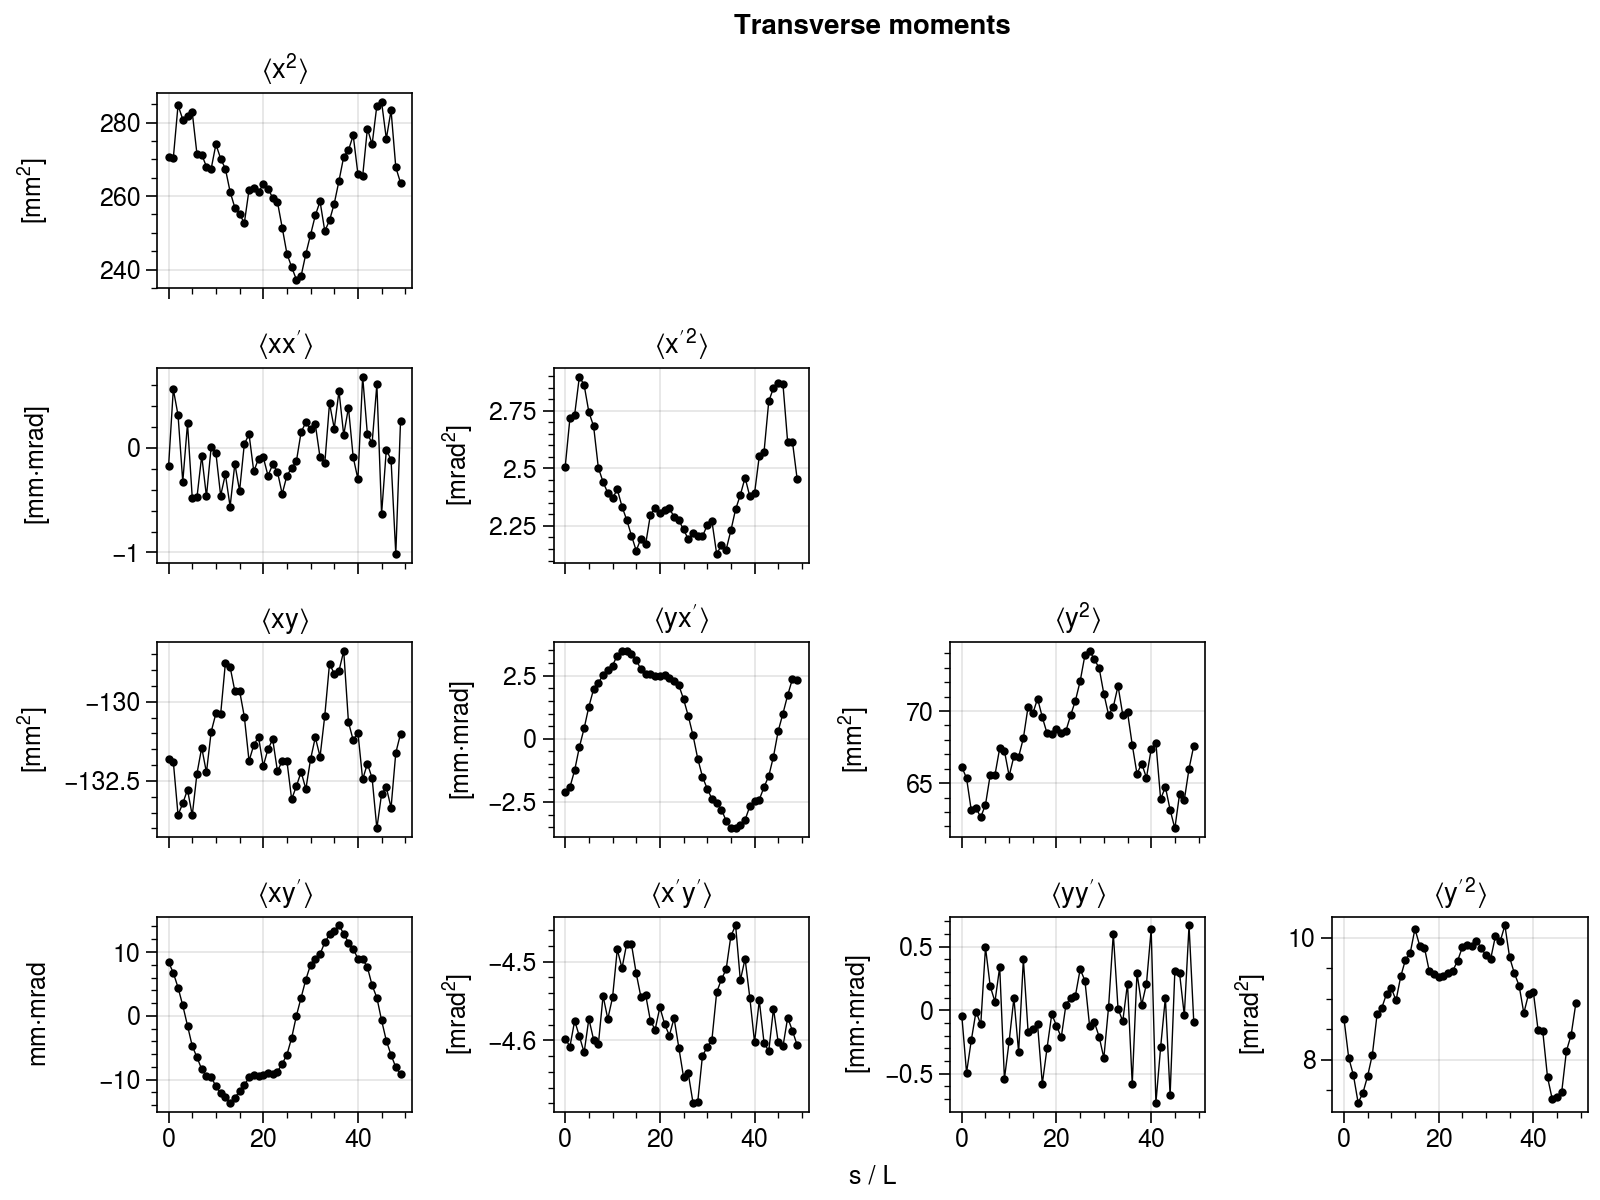

In [12]:
fig, axes = plot.subplots(nrows=4, ncols=4, sharey=False, figsize=(8, 6), 
                          spany=False, aligny=True)
myplt.make_lower_triangular(axes)
axes.format(xlabel='s / L', suptitle='Transverse moments', titleborder=True)

for i in range(4):
    for j in range(i + 1):
        ax = axes[i, j]
        col = utils.get_moments_key(i, j)
        env_stats.moments[col].plot(ax=ax, color='k', marker='o', ms=2, lw=0.5)
        ax.format(title=utils.get_moments_label(i, j))

set_labels(axes[0:, 0], [r'[mm$^2$]', r'[mm$\cdot$mrad]', r'[mm$^2$]', r'mm$\cdot$mrad'], 'ylabel')
set_labels(axes[1:, 1], [r'[mrad$^2$]', r'[mm$\cdot$mrad]', r'[mrad$^2$]'], 'ylabel')
set_labels(axes[2:, 2], [r'[mm$^2$]', r'[mm$\cdot$mrad]'], 'ylabel')
set_labels(axes[3:, 3], [r'[mrad$^2$]'], 'ylabel')
save('all_moments', dirs['env'], dpi=dpi)

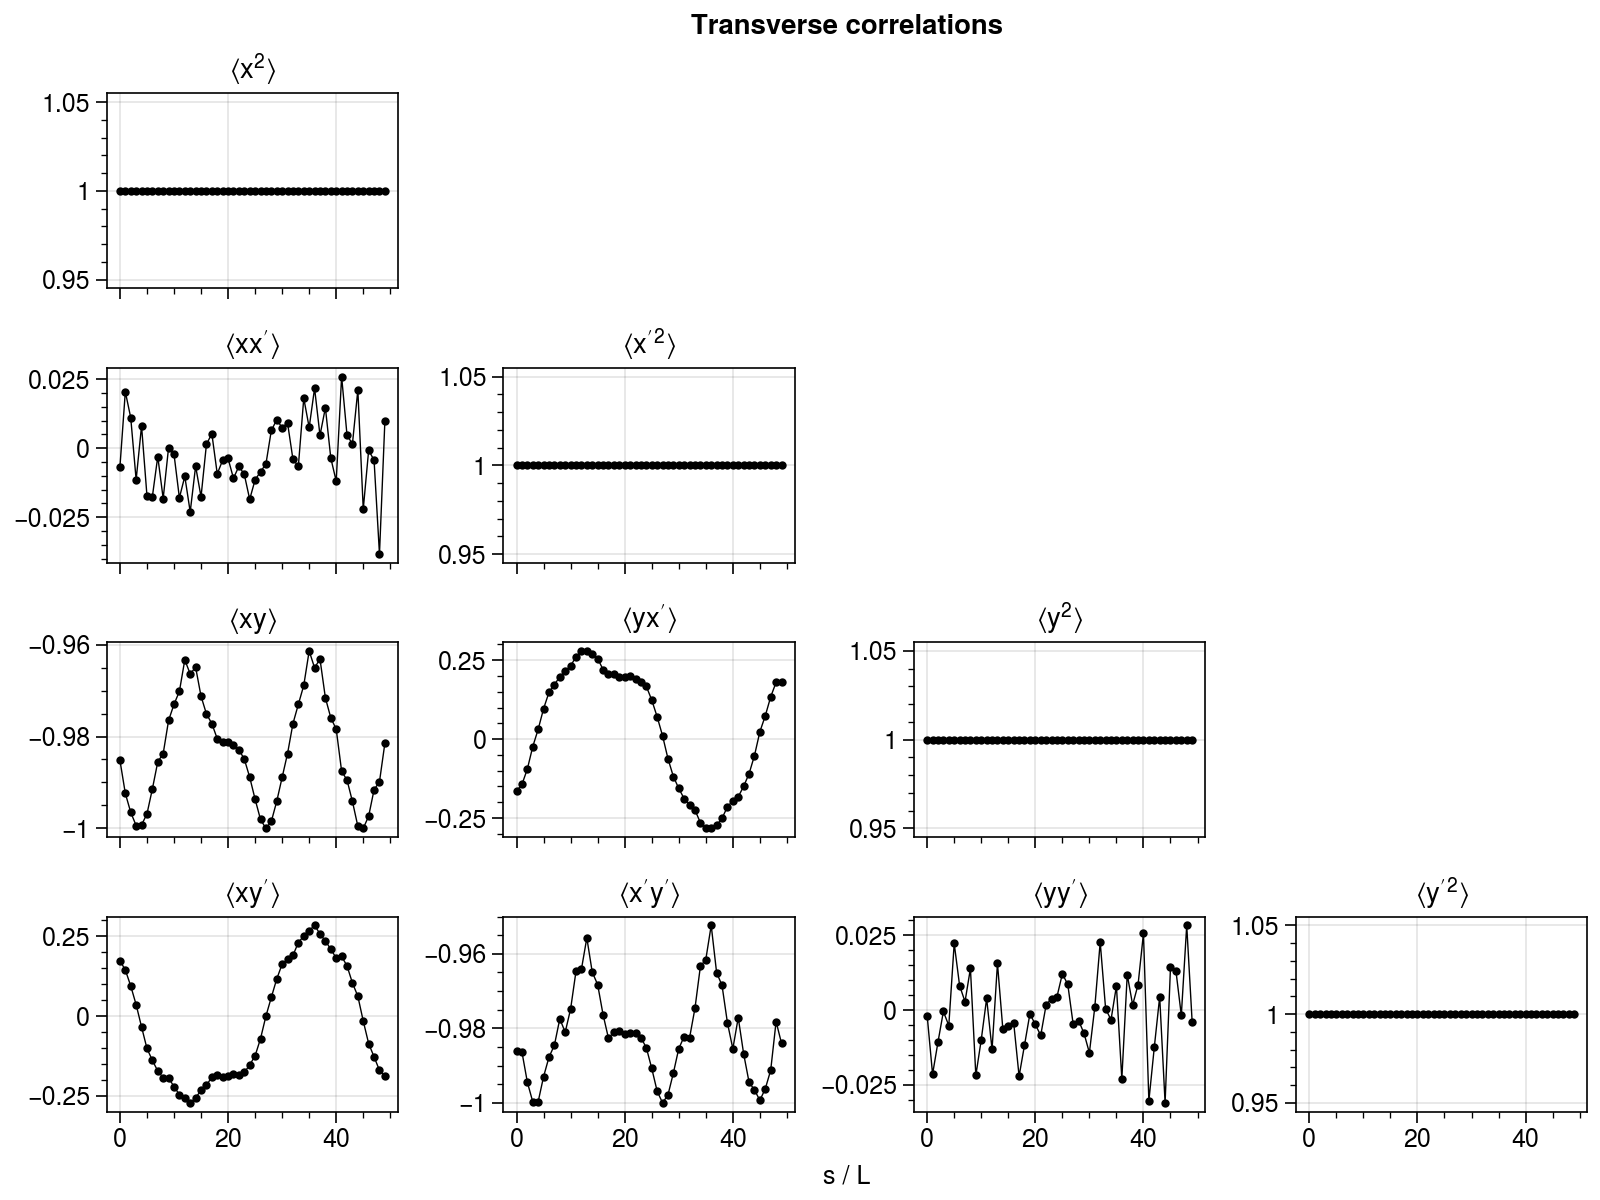

In [13]:
fig, axes = plot.subplots(nrows=4, ncols=4, sharey=False, figsize=(8, 6), 
                          spany=False, aligny=True)
myplt.make_lower_triangular(axes)
axes.format(xlabel='s / L', suptitle='Transverse correlations', titleborder=True)

for i in range(4):
    for j in range(i + 1):
        ax = axes[i, j]
        col = utils.get_moments_key(i, j)
        env_stats.corr[col].plot(ax=ax, color='k', marker='o', ms=2, lw=0.5)
        ax.format(title=utils.get_moments_label(i, j))

save('all_correlations', dirs['env'], dpi=dpi)

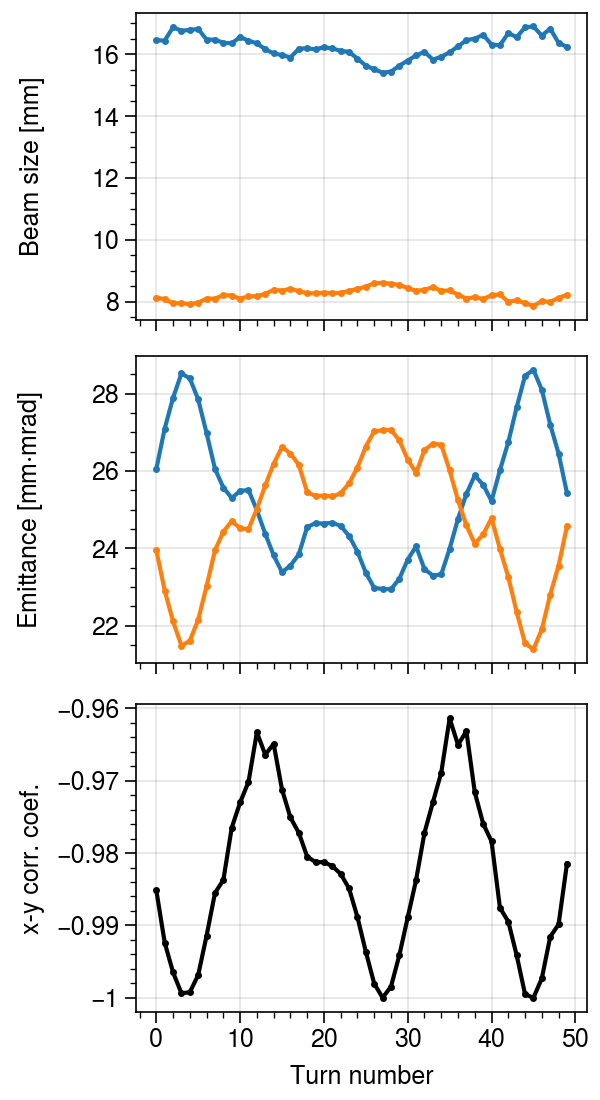

In [14]:
fig, axes = plot.subplots(nrows=3, figsize=(3, 5.5), spany=False, aligny=True)
env_stats.moments[['x_rms','y_rms']].plot(ax=axes[0], **plt_kws)
env_stats.twiss2D[['ex','ey']].plot(ax=axes[1], **plt_kws)
env_stats.corr[['xy']].plot(ax=axes[2], color='k', **plt_kws)
set_labels(axes, ['Beam size [mm]', r'Emittance [mm$\cdot$mrad]', 'x-y corr. coef.'], 'ylabel')
axes.format(xlabel='Turn number')
save('misc', dirs['env'], dpi=dpi)

## Real space orientation

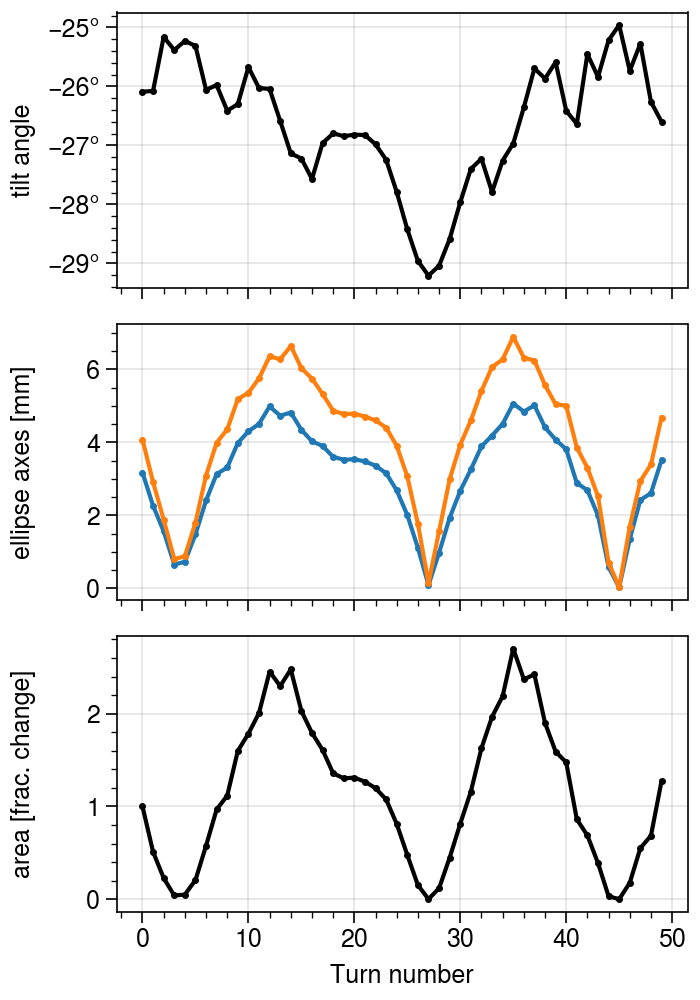

In [15]:
fig, axes = setup_figure(2)
env_stats.realspace[['angle']].plot(ax=axes[0], color='k', **plt_kws)
env_stats.realspace[['cx','cy']].plot(ax=axes[1], **plt_kws)
env_stats.realspace[['area_rel']].plot(ax=axes[2], color='k', **plt_kws)
set_labels(axes, ['tilt angle', 'ellipse axes [mm]', 'area [frac. change]'], 'ylabel')
axes.format(xlabel='Turn number')
axes[0].format(yformatter='deg')
save('beam_dims', dirs['env'], dpi=dpi)

## Tunes 

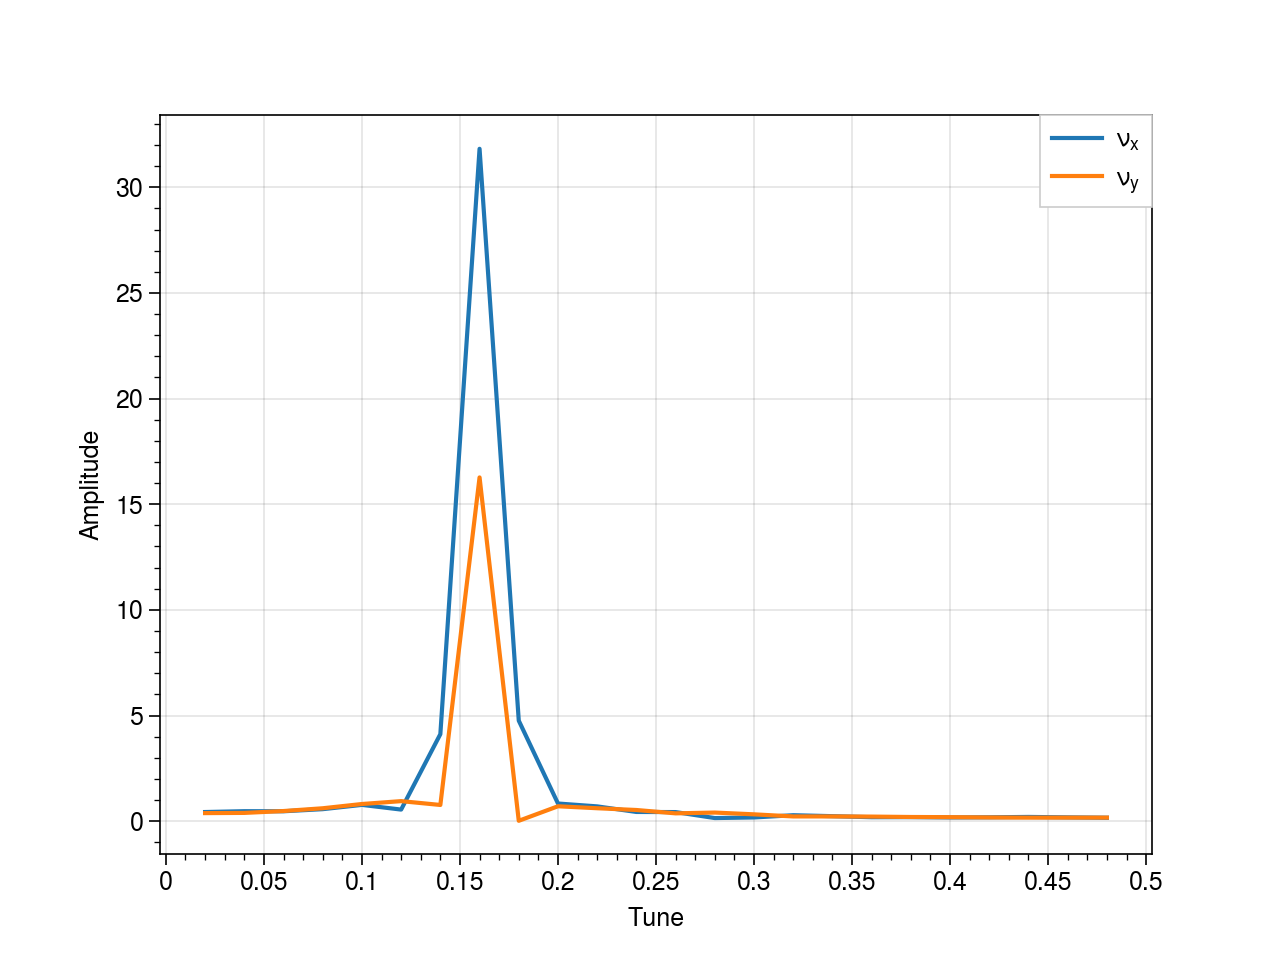

In [16]:
X = ea.get_coord_array(env_params, 50)
ax = myplt.fft(X[:, 0, 0], X[:, 0, 2], grid=True, legend=True, figname=None)

## Phase space projections 

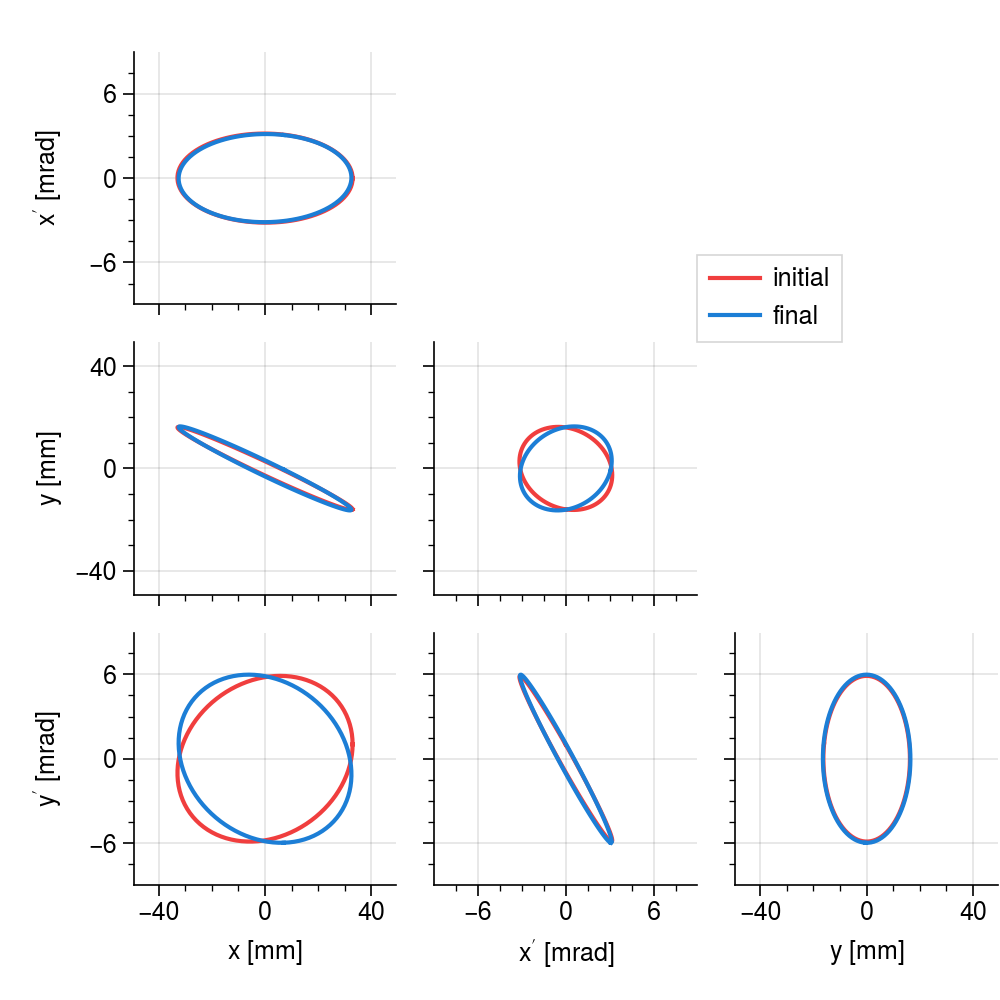

In [17]:
axes = myplt.corner_env(
    env_params[[0, -1]], cmap=plot.Colormap(('red7', 'blue7')),
    legend_kws=dict(labels=['initial','final'], loc=(1, 1))
)
save('init_final', dirs['env'], dpi=dpi)
save('init_final', dirs['env'], dpi=dpi)

In [18]:
anim = myanim.corner_env(env_params[t0:t1], skip=skip, show_init=True, 
                         fps=fps, figsize=5, text_fmt='Turn = {}')
play(anim)

Plot snapshots of the beam in real space.

In [19]:
turns = [0, 1, 2, 3, 4, 5]

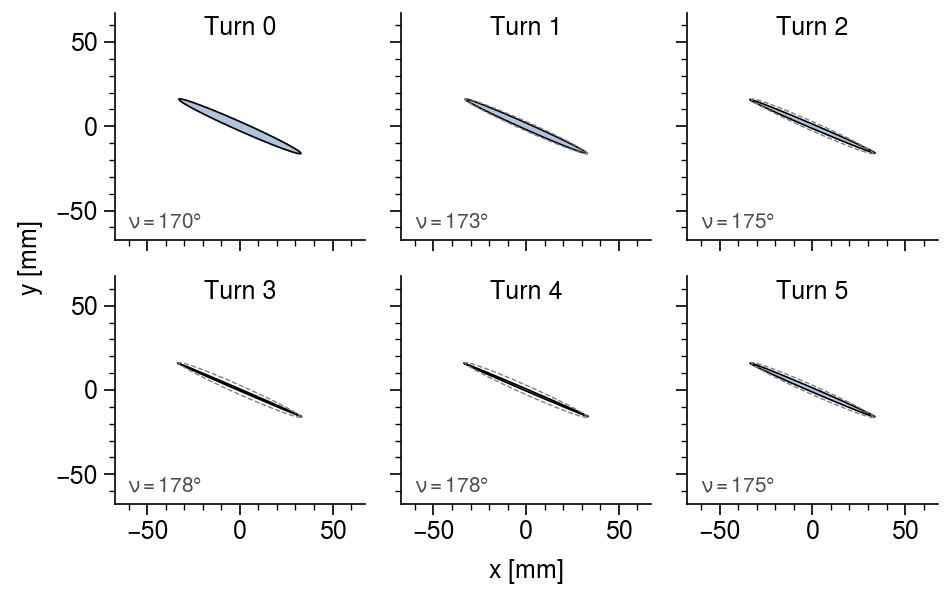

In [20]:
ellipse_coords_list = ea.get_ellipse_coords(env_params[turns])
X0 = ellipse_coords_list[0]
umax, upmax = myplt.get_u_up_max_global(ellipse_coords_list)
umax *= 2

fig, axes = plot.subplots(nrows=2, ncols=3, figsize=(4.75, 3))
myplt.despine(axes)
axes.format(grid=False, ylabel=r'$y$ [mm]', xlabel=r'$x$ [mm]', 
            xlim=(-umax, umax), ylim=(-umax, umax), 
            xlocator=('maxn', 3), ylocator=('maxn', 3))


for i, (ax, X) in enumerate(zip(axes, ellipse_coords_list)):
    t = turns[i]
    ax.plot(X0[:, 0], X0[:, 2], '--', lw=0.5, color='grey', zorder=0 if i == 0 else 3)
    ax.fill(X[:, 0], X[:, 2], ec='k', fc='lightsteelblue', zorder=2)
    ax.annotate('Turn {}'.format(t), xy=(0.5, 0.9), horizontalalignment='center', xycoords='axes fraction')
    nu = env_stats.twiss4D.loc[t, 'nu']
    ax.annotate(r'$\nu = {:.0f}\degree$'.format(nu), xy=(0.05, 0.05), 
                xycoords='axes fraction', alpha=0.7, fontsize='small')
    ax.invert_xaxis() # ???
save('tbt_snapshots', dirs['env'], dpi=dpi)

Show the beam parameters over this range of turns.

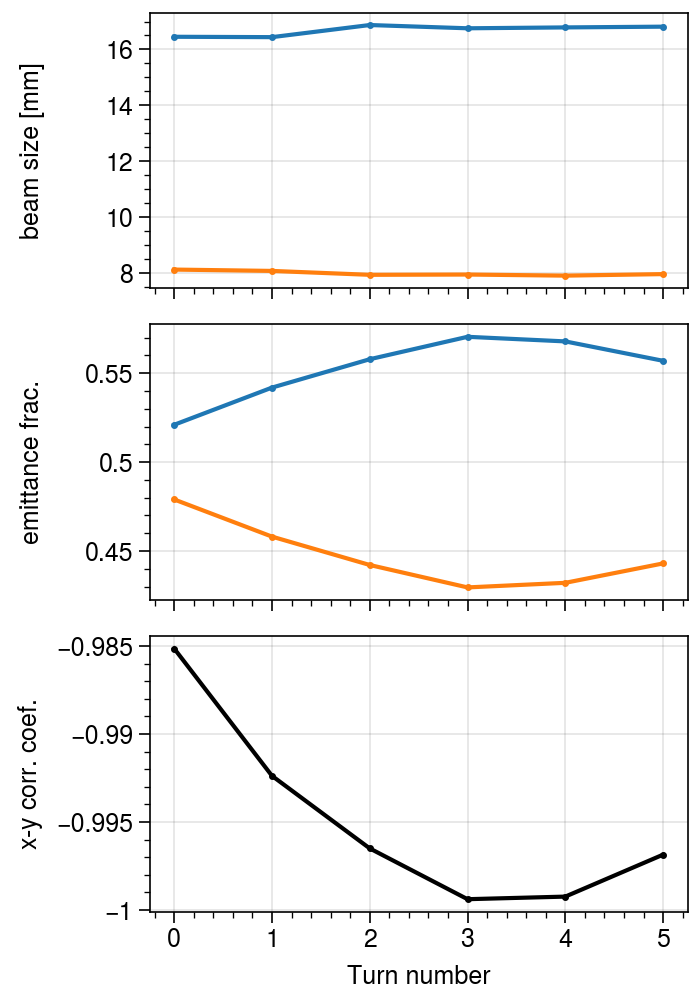

In [21]:
fig, axes = setup_figure(2)

env_stats.moments.loc[:turns[-1], ['x_rms','y_rms']].plot(ax=axes[0], **plt_kws)
env_stats.twiss2D.loc[:turns[-1], ['ex_frac','ey_frac']].plot(ax=axes[1], **plt_kws)
env_stats.corr.loc[:turns[-1], 'xy'].plot(ax=axes[2], color='k', **plt_kws)

axes.format(xlabel='Turn number')
set_labels(axes, ['beam size [mm]', 'emittance frac.', r'$x$-$y$ corr. coef.'], 'ylabel')
save('tbt', dirs['env'], dpi=dpi)

## Transfer matrix 

In [22]:
if files_exist['transfer_matrix']:
    M = np.load(files['transfer_matrix'])
    M_eigvals, M_eigvecs = np.linalg.eig(M)
    M_eigtunes = np.degrees(np.arccos(M_eigvals.real))

    show(M, 'M')
    print()
    show(M_eigvals[[0, 2]], 'eigenvalues')
    print()
    show(M_eigtunes[[0, 2]], 'eigentunes [deg]')

/Users/46h/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in arccos
  after removing the cwd from sys.path.


M =
⎡1.344  17.648  1.909  3.884⎤
⎢                           ⎥
⎢0.464  6.701   1.292  2.728⎥
⎢                           ⎥
⎢0.871  9.668   2.612  6.556⎥
⎢                           ⎥
⎣1.069  12.091  2.232  5.911⎦

eigenvalues =
⎡    15.411     ⎤
⎢               ⎥
⎣0.546 - 0.838⋅ⅈ⎦

eigentunes [deg] =
⎡ nan  ⎤
⎢      ⎥
⎣56.925⎦


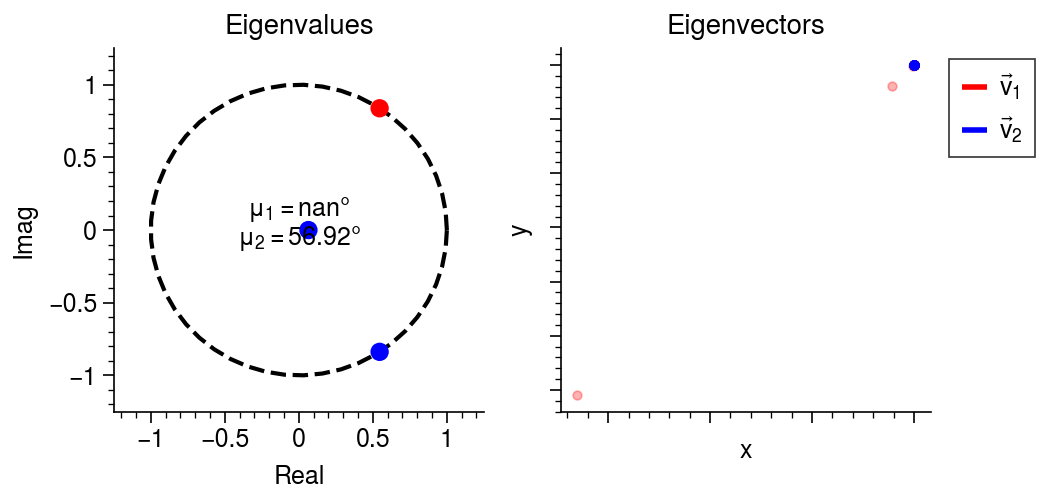

In [23]:
if files_exist['transfer_matrix']:
    
    fig, axes = plot.subplots(ncols=2, figsize=(5.25, 2.5), share=False, span=False)
    axes.format(grid=False)
    myplt.despine(axes)
    ax1, ax2 = axes

    # Plot eigenvalues in complex plane
    psi = np.linspace(0, 2*np.pi, 50)
    x_circ, y_circ = np.cos(psi), np.sin(psi)
    ax1.plot(x_circ, y_circ, 'k--', zorder=0)
    ax1.scatter(M_eigvals.real, M_eigvals.imag, c=['r','r','b','b'])
    scale = 1.25
    ax1.format(
        xticks=[-1, -0.5, 0, 0.5, 1], yticks=[-1, -0.5, 0, 0.5, 1], 
        ylim=(-scale, scale), xlim=(-scale, scale),
        xlabel='Real', ylabel='Imag', title='Eigenvalues')
    ax1.annotate(r'$\mu_1 = {:.2f}\degree$'.format(M_eigtunes[0]), xy=(0, +0.1), horizontalalignment='center')
    ax1.annotate(r'$\mu_2 = {:.2f}\degree$'.format(M_eigtunes[2]), xy=(0, -0.1), horizontalalignment='center')

    # Plot turn-by-turn trajectory of eigenvectors
    myplt.eigvec_trajectory(ax2, M, 'x', 'y', s=10)
    ax2.format(xticklabels=[], yticklabels=[], 
               ylabel='y', xlabel='x', title='Eigenvectors')

    # Add legend
    custom_lines = [matplotlib.lines.Line2D([0], [0], color='r', lw=2),
                    matplotlib.lines.Line2D([0], [0], color='b', lw=2)]
    ax2.legend(custom_lines, [r'$\vec{v}_1$', r'$\vec{v}_2$'],
               loc=(1.05, 0.7), handlelength=1, ncols=1);

    save('eigvecs_realspace', dirs['env'], dpi=dpi)

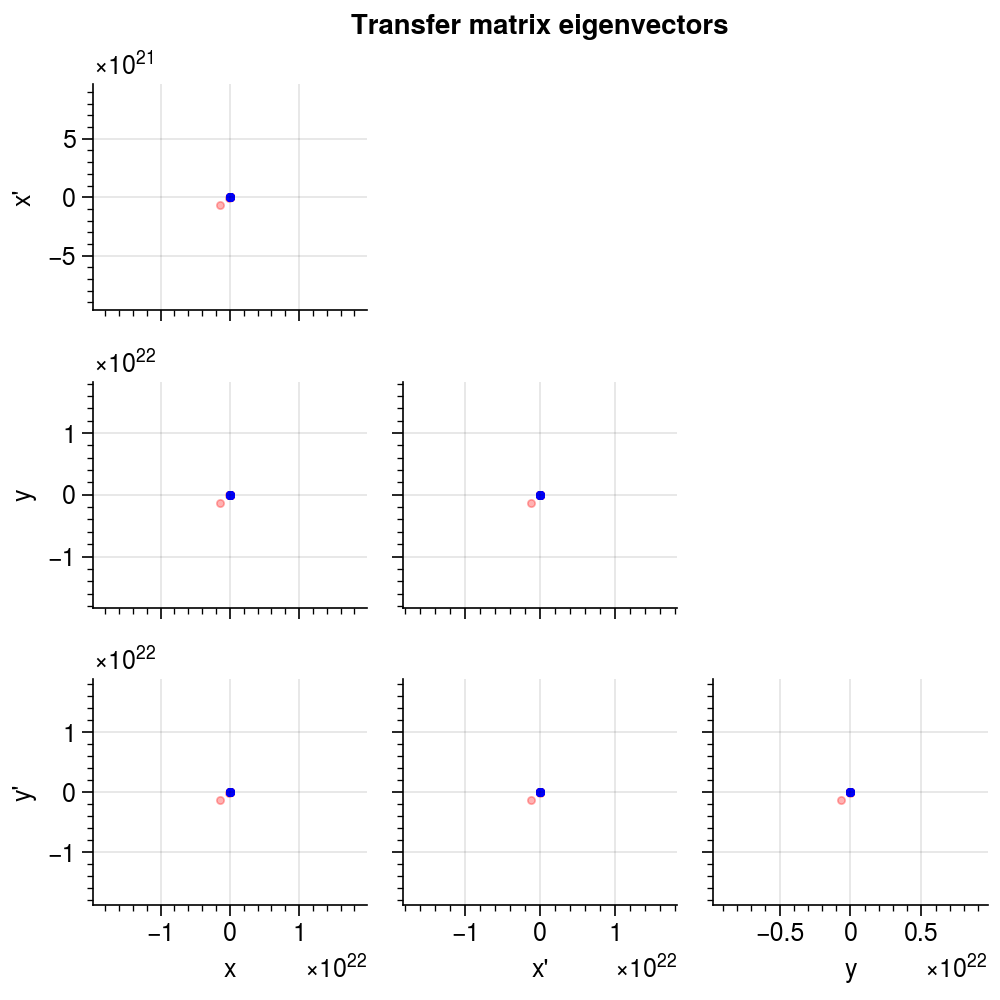

In [24]:
if files_exist['transfer_matrix']:
    
    # Set up figure
    fig, axes = plot.subplots(nrows=3, ncols=3, figsize=(5, 5), span=False)
    axes.format(grid=True, suptitle='Transfer matrix eigenvectors')
    myplt.make_lower_triangular(axes)
    myplt.despine(axes)

    labels = ["x", "x'", "y", "y'"]
    xlabels, ylabels = labels[:-1], labels[1:]
    set_labels(axes[-1, :], xlabels, 'xlabel')
    set_labels(axes[:, 0], ylabels, 'ylabel')

    # Plot eigenvectors and their trajectories
    for i in range(3):
        for j in range(3):
            if i >= j:
                ax = axes[i, j]
                yvar = ['xp', 'y', 'yp'][i]
                xvar = ['x', 'y', 'xp'][j]
                myplt.eigvec_trajectory(ax, M, xvar, yvar, s=7, lw=1)

    # Zoom out a bit
    for i in range(3):
        ymin, ymax = axes[i, 0].get_ylim()
        xmin, xmax = axes[-1, i].get_xlim()
        scale = 1.2
        axes[i, :].format(ylim=(-scale*ymax, scale*ymax))
        axes[:, i].format(xlim=(-scale*xmax, scale*xmax))

    save('eigvecs', dirs['env'], dpi=dpi)

## Test bunch

The linear space charge kicks for the test bunch are calculated directly from the envelope parameters.

In [25]:
if files_exist['testbunch_coords']:
    
    test_coords = np.load(files['testbunch_coords'])
    nframes, ntestparts, ndims = test_coords.shape
    print('Test bunch coordinates:')
    print('nparts, nframes = {}, {}'.format(ntestparts, nframes))
    
    test_cdfs = []
    for X in test_coords:
        cdf = pd.DataFrame(X, columns=['x','xp','y','yp'])
        test_cdfs.append(cdf)

Test bunch coordinates:
nparts, nframes = 100, 50


# Bunch
This section performs the same analysis for the bunch tracked with PyORBIT (if it was tracked).

In [26]:
if files_exist['bunch_coords']:
    coords = np.load(files['bunch_coords'])    
    cdfs = []
    for X in coords:
        cdf = pd.DataFrame(X, columns=['x','xp','y','yp'])
        cdfs.append(cdf)
    print('Bunch coordinates:')
    print('nframes, nparts = {}, {}'.format(*coords.shape))
        
if files_exist['bunch_moments']:
    moments = np.load(files['bunch_moments'])
    bunch_stats = ea.Stats(mode)
    bunch_stats.read_moments(moments)

## Twiss parameters 

### 2D Twiss

In [27]:
if files_exist['bunch_moments']:
    fig, axes = setup_figure(2)
    columns = (['bx','by'], ['ax','ay'], ['ex','ey'])
    ylabels = (r'$\beta$ [m]', r'$\alpha$ [rad]', r'$\varepsilon$ [mm $\cdot$ mrad]')
    for ax, col in zip(axes, columns):
        bunch_stats.twiss2D[col].plot(ax=ax, **plt_kws)
        axes.format(xlabel='Turn number')
    set_labels(axes, ylabels, 'ylabel')
    save('twiss2D', dirs['bunch'], dpi=dpi)

### Emittance 

In [28]:
if files_exist['bunch_moments']:
    fig, ax = plot.subplots(figsize=(4.5, 2.5))
    bunch_stats.twiss2D[['ex','ey']].plot(ax=ax, **plt_kws)
    bunch_stats.twiss4D[['e1','e2']].plot(ax=ax, **plt_kws)
    ax.format(ylabel=r'$\varepsilon$ [mm $\cdot$ mrad]')
    ax.legend(labels=[r'$\varepsilon_x$', r'$\varepsilon_y$', r'$\varepsilon_1$', r'$\varepsilon_2$'], 
              ncols=1, loc=(1.01, 0))
    save('emittance', dirs['bunch'], dpi=dpi)

## Moments 

In [29]:
if files_exist['bunch_moments']:
    fig, ax = setup_figure(1)
    bunch_stats.moments[['x_rms','y_rms']].plot(ax=ax, **plt_kws)
    ax.format(xlabel='Turn number', ylabel='Beam size [mm]')
    save('beamsize', dirs['bunch'], dpi=dpi)

In [30]:
if files_exist['bunch_moments']:
    fig, ax = setup_figure(1)
    bunch_stats.moments[['xp_rms','yp_rms']].plot(ax=ax, **plt_kws)
    ax.format(xlabel='Turn number', ylabel='Beam div. [mrad]')
    save('beamdiv', dirs['bunch'], dpi=dpi)

In [31]:
if files_exist['bunch_moments']:
    fig, axes = plot.subplots(nrows=4, ncols=4, sharey=False, figsize=(8, 6), 
                          spany=False, aligny=True)
    myplt.make_lower_triangular(axes)
    axes.format(xlabel='s / L', suptitle='Transverse moments', titleborder=True)

    for i in range(4):
        for j in range(i + 1):
            ax = axes[i, j]
            col = utils.get_moments_key(i, j)
            bunch_stats.moments[col].plot(ax=ax, color='k', marker='o', ms=2, lw=0.5)
            ax.format(title=utils.get_moments_label(i, j))

    set_labels(axes[0:, 0], [r'[mm$^2$]', r'[mm$\cdot$mrad]', r'[mm$^2$]', r'mm$\cdot$mrad'], 'ylabel')
    set_labels(axes[1:, 1], [r'[mrad$^2$]', r'[mm$\cdot$mrad]', r'[mrad$^2$]'], 'ylabel')
    set_labels(axes[2:, 2], [r'[mm$^2$]', r'[mm$\cdot$mrad]'], 'ylabel')
    set_labels(axes[3:, 3], [r'[mrad$^2$]'], 'ylabel')
    save('all_moments', dirs['bunch'], dpi=dpi)

In [32]:
if files_exist['bunch_moments']:
    fig, axes = plot.subplots(nrows=4, ncols=4, sharey=False, figsize=(8, 6), 
                          spany=False, aligny=True)
    myplt.make_lower_triangular(axes)
    axes.format(xlabel='s / L', suptitle='Transverse correlations', titleborder=True)

    for i in range(4):
        for j in range(i + 1):
            ax = axes[i, j]
            col = utils.get_moments_key(i, j)
            bunch_stats.corr[col].plot(ax=ax, color='k', marker='o', ms=2, lw=0.5)
            ax.format(title=utils.get_moments_label(i, j))

    save('all_correlations', dirs['bunch'], dpi=dpi)

## Beam orientation

In [33]:
if files_exist['bunch_moments']:
    fig, axes = setup_figure(2)
    bunch_stats.realspace[['angle']].plot(ax=axes[0], **plt_kws)
    bunch_stats.realspace[['cx','cy']].plot(ax=axes[1], **plt_kws)
    bunch_stats.realspace[['area_rel']].plot(ax=axes[2], color='k', **plt_kws)
    set_labels(axes, ['tilt angle', 'ellipse axes [mm]', 'area [frac. change]'], 'ylabel')
    ax.format(xlabel='Turn number')
    axes[0].format(yformatter='deg')
    save('beam_dims', dirs['bunch'], dpi=dpi)

## Phase space projections 

In [34]:
if files_exist['bunch_coords']:
    for i, name in zip((1, -1), ('Initial', 'Final')):
        axes = myplt.corner(coords[i], text=name, figsize=5.5)
        save(name, dirs['bunch'], dpi=dpi)

In [35]:
if files_exist['bunch_coords']:
    anim = myanim.corner(coords[t0:t1], skip=skip, diag_kind='hist', fps=fps, 
                         text_fmt='Turn = {}', figsize=6)
    play(anim)

# Comparison 
Compare the theory (envelope calculation) to the PIC simulation.

In [36]:
if files_exist['bunch_moments']:
    
    plt_kws_env = dict(
        lw=None,
        marker=None,
        markersize=None,
        color='black',
        legend=False,
    )
    plt_kws_bunch = dict(
        lw=0,
        marker='.',
        markersize=None,
        color='red',
        legend=False,
    )
    dataframes = [env_stats, bunch_stats]
    kws_list = [plt_kws_env, plt_kws_bunch]

## Moments

In [37]:
if files_exist['bunch_moments']:
    fig, axes = setup_figure(4)
    for ax, key in zip(axes, ('x_rms', 'y_rms')):
        for df, kws in zip(dataframes, kws_list):
            df.moments[key].plot(ax=ax, **kws)
    axes.format(xlabel='Turn number', ylabel='[mm]')
    set_labels(axes, [r'$\sqrt{\langle{x^2}\rangle}$', r'$\sqrt{\langle{y^2}\rangle}$'], 'title')
    axes[1].legend(labels=['theory', 'calc'], ncols=1, loc=(1.02, 0), fontsize='small')
    save('beamsize', dirs['comparison'], dpi=dpi)

In [38]:
if files_exist['bunch_moments']:
    fig, axes = setup_figure(4)
    for ax, key in zip(axes, ('xp_rms', 'yp_rms')):
        for df, kws in zip(dataframes, kws_list):
            df.moments[key].plot(ax=ax, **kws)
    axes.format(xlabel='Turn number', ylabel='[mrad]')
    set_labels(axes, [r"$\sqrt{\langle{x'^2}\rangle}$", r"$\sqrt{\langle{y'^2}\rangle}$"], 'title')
    axes[1].legend(labels=['theory', 'calc'], ncols=1, loc=(1.02, 0), fontsize='small')
    save('up', dirs['comparison'], dpi=dpi)

In [39]:
if files_exist['bunch_moments']:
    fig, ax = plot.subplots(figsize=(1.25*width, height))
    for df, kws in zip(dataframes, kws_list):
        df.corr['xy'].plot(ax=ax, **kws)
    ax.format(title=r"$x$-$y$ corr. coef.", xlabel='Turn number')
    ax.legend(labels=['theory', 'calc'], ncols=1, loc=(1.02, 0), fontsize='small')
    save('xy_corr', dirs['comparison'], dpi=dpi)

In [40]:
if files_exist['bunch_moments']:
    
    fig, axes = plot.subplots(nrows=4, ncols=4, sharey=False, figsize=(8, 6), 
                              spany=False, aligny=True)
    myplt.make_lower_triangular(axes)
    axes.format(xlabel='s / L', suptitle='Transverse moments', titleborder=True)

    for df, kws in zip(dataframes, kws_list):
        for i in range(4):
            for j in range(i + 1):
                ax = axes[i, j]
                col = utils.get_moments_key(i, j)
                df.moments[col].plot(ax=ax, **kws)
                ax.format(title=utils.get_moments_label(i, j))

    set_labels(axes[0:, 0], [r'[mm$^2$]', r'[mm$\cdot$mrad]', r'[mm$^2$]', r'mm$\cdot$mrad'], 'ylabel')
    set_labels(axes[1:, 1], [r'[mrad$^2$]', r'[mm$\cdot$mrad]', r'[mrad$^2$]'], 'ylabel')
    set_labels(axes[2:, 2], [r'[mm$^2$]', r'[mm$\cdot$mrad]'], 'ylabel')
    set_labels(axes[3:, 3], [r'[mrad$^2$]'], 'ylabel')
    save('all_moments', dirs['comparison'], dpi=dpi)

In [41]:
if files_exist['bunch_moments']:
    
    fig, axes = plot.subplots(nrows=4, ncols=4, sharey=False, figsize=(8, 6), 
                              spany=False, aligny=True)
    myplt.make_lower_triangular(axes)
    axes.format(xlabel='s / L', suptitle='Transverse correlations', titleborder=True)

    for df, kws in zip(dataframes, kws_list):
        for i in range(4):
            for j in range(i + 1):
                ax = axes[i, j]
                col = utils.get_moments_key(i, j)
                df.corr[col].plot(ax=ax, **kws)
                ax.format(title=utils.get_moments_label(i, j))
                
    save('all_moments', dirs['comparison'], dpi=dpi)

## Twiss parameters

### 2D Twiss 

In [42]:
if files_exist['bunch_moments']:
    fig, axes = setup_figure(3)
    for df, kws in zip(dataframes, kws_list):
        df.twiss2D['bx'].plot(ax=axes[0, 0], **kws)
        df.twiss2D['by'].plot(ax=axes[0, 1], **kws)
        df.twiss2D['ax'].plot(ax=axes[1, 0], **kws)
        df.twiss2D['ay'].plot(ax=axes[1, 1], **kws)
        df.twiss2D['ex'].plot(ax=axes[2, 0], **kws)
        df.twiss2D['ey'].plot(ax=axes[2, 1], **kws)
    axes.format(xlabel='Turn number', collabels=['Horizontal', 'Vertical'])
    set_labels(axes[:, 0], [r'$\beta$ [m]', r'$\alpha$ [rad]', r'$\varepsilon$ [mm $\cdot$ mrad]'], 'ylabel')
    save('twiss2D', dirs['comparison'], dpi=dpi)

In [43]:
if files_exist['bunch_moments']:
    fig, axes = setup_figure(3)
    for df, kws in zip(dataframes, kws_list):
        df.twiss4D['bx'].plot(ax=axes[0, 0], **kws)
        df.twiss4D['by'].plot(ax=axes[0, 1], **kws)
        df.twiss4D['ax'].plot(ax=axes[1, 0], **kws)
        df.twiss4D['ay'].plot(ax=axes[1, 1], **kws)
        df.twiss4D['u'].plot(ax=axes[2, 0], **kws)
    axes.format(xlabel='Turn number', collabels=['Horizontal', 'Vertical'])
    set_labels(axes[:, 0], [r'$\beta$ [m]', r'$\alpha$ [rad]', 'u'], 'ylabel')
    save('twiss4D', dirs['comparison'], dpi=dpi)

## Beam dimensions 

In [44]:
if files_exist['bunch_moments']:
    fig, axes = plot.subplots(nrows=2, figsize=(width, 1.5*height), spany=False, aligny=True)
    for df, kws in zip(dataframes, kws_list):
        df.realspace['angle'].plot(ax=axes[0], **kws)
        df.realspace['area'].plot(ax=axes[1], **kws)
    axes.format(xlabel='Turn number')
    for ax, ylabel in zip(axes, ['tilt angle', r'area [mm$^2$]']):
        ax.format(ylabel=ylabel)
    axes[0].format(yformatter='deg')
    save('beam_dims', dirs['comparison'], dpi=dpi)

## Phase space projections

In [45]:
if files_exist['bunch_coords']:
    for i, name in zip((0, -1), ('Initial', 'Final')):
        axes = myplt.corner(coords[i], env_params[i], text=name, diag_kind='none', figsize=4.5)
        save(name, dirs['comparison'], dpi=dpi)

In [46]:
if files_exist['bunch_coords']:
    anim = myanim.corner(coords[t0:t1], env_params[t0:t1], skip=skip, figsize=5.5, 
                         diag_kind='none', fps=fps, text_fmt='Turn = {}')
    play(anim)